LOGIC WALKTHROUGH:
1. Initialise replay memory capacity.
2. Initialise the network with random weights.
3. For each episode:
    1. Initialise the starting state.
    2. For each time step:
        1. Select an action (exploration or exploitation).
        2. Execute selected action in an emulator.
        3. Observe reward and next state.
        4. Store experience in replay memory.
        5. Sample random batch from replay memory.
        6. Preprocess states from batch.
        7. Pass batch of preprocessed states to policy network.
        8. Calculate loss between output Q-values and target Q-values (this requires a second pass to the network for the next state).
        9. Gradient descent updates weights in the policy network to minimise loss (after x time steps, weights in the target network are updated to the weights in the policy network).

In [181]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# #! = include this line for the original code.

In [182]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

### Build deep q-network:

In [183]:
# the DQN receives screenshots of the cartpole environment as input, so we need to crop the images by
# inputting a height and width.
class DQN(nn.Module):
    # def __init__(self, img_height, img_width):
    def __init__(self, num_state_features):
        super().__init__()

        # 3 responds to the RGB colours.
        # the output values correspond to the Q-values that the agent can take from a given state.
        # our only available actions are for the cart to move LEFT or RIGHT, ∴ we only have 2 outputs for self.out.
        #!self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)
        self.fc1 = nn.Linear(in_features=num_state_features, out_features=24) # remove this line for OG code.
        self.fc2 = nn.Linear(in_features=24, out_features=32) # first layer accepts 24 inputs, and produces 32 outputs.
        self.out = nn.Linear(in_features=32, out_features=2) # ∴ next layer expects 32 inputs, and produces 2 outputs.

    # implement a "foward pass" to the network.
    def forward(self, t):
        #! t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

### Experience class:

In [184]:
# the tuple is named "Experience", and it has the subfields state, action, next_state, and reward.
# this is each individual experience.
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

### Replay memory:

In [185]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [] # this is the structure to hold the experiences.
        self.push_count = 0 # track how many experiences we've added to 'memory'.

    def push(self, experience):
        # check that the amount of experiences already in 'memory' are LESS than the memory's capacity.
        # if YES, then add experience to memory.
        # if NO, then push new experiences to the front of memory and overwrite the oldest experiences.
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    # get random sample of experiences.
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    # make sure the memory batch is at full capacity before a sample is provided!
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

### Epsilon-Greedy strategy:

In [186]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

### Reinforcement learning agent:

In [187]:
class Agent():
    # the device is the device used by pytorch for tensor calculations.
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    # policy network is the deep q-network that we train to obtain the optimal policy.
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            # added this (2 lines):
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore
            #return random.randrange(self.num_actions) # explore
        else:
            with torch.no_grad():
                #! return policy_net(state).argmax(dim=1).to(self.device) # exploit
                # remove line below for original code.
                return policy_net(state).unsqueeze(dim=0).argmax(dim=1).to(self.device)

### Environment manager:

In [188]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v1').unwrapped
        self.env.reset()
        #! self.current_screen = None
        self.current_state = None # remove this line for original code.
        self.done = False
    
    def reset(self):
        #! self.env.reset()
        #! self.current_screen = None
        self.current_state = self.env.reset()
    
    def close(self):
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)

    # only 2 actions available-- left or right.
    def num_actions_available(self):
        return self.env.action_space.n

    def take_action(self, action):
        #! _, reward, self.done, _ = self.env.step(action.item())
        self.current_state, reward, self.done, _ = self.env.step(action.item()) # remove this line for original code.
        return torch.tensor([reward], device=self.device)

    #!def just_starting(self):
        #return self.current_screen is None

    def get_state(self):
        #! if self.just_starting() or self.done:
        #     self.current_screen = self.get_processed_screen()
        #     black_screen = torch.zeros_like(self.current_screen)
        #     return black_screen
        # else:
        #     s1 = self.current_screen
        #     s2 = self.get_processed_screen()
        #     self.current_screen = s2
        #     # state is the difference between 2 consecutive screens.
        #     return s2 - s1
        if self.done: # remove this line up to and including line 49 for original code.
            return torch.zeros_like(
                torch.tensor(self.current_state), device=self.device
            ).float()
        else:
            return torch.tensor(self.current_state, device=self.device).float()

    # remove the function below for original code.
    def num_state_features(self):
        return self.env.observation_space.shape[0]
    
    # def get_screen_height(self):
    #     screen = self.get_processed_screen()
    #     return screen.shape[2]

    # def get_screen_width(self):
    #     screen = self.get_processed_screen()
    #     return screen.shape[3]

    # def get_processed_screen(self):
    #     screen = self.render('rgb_array').transpose((2, 0, 1))
    #     screen = self.crop_screen(screen)
    #     return self.transform_screen_data(screen)

    # def crop_screen(self, screen):
    #     screen_height = screen.shape[1]

    #     # strip off top and bottom
    #     top = int(screen_height * 0.4)
    #     bottom = int(screen_height * 0.8)
    #     screen = screen[:, top:bottom, :]
    #     return screen

    # def transform_screen_data(self, screen):
    #     # convert to float, rescale, convert to tensor
    #     screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    #     screen = torch.from_numpy(screen)

    #     # use torchvision package to compose image transforms
    #     resize = T.Compose([
    #         T.ToPILImage()
    #         ,T.Resize((40,90))
    #         ,T.ToTensor()
    #     ])

    #     return resize(screen).unsqueeze(0).to(self.device)

### Tensor processing:

In [189]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))

    t1 = torch.stack(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.stack(batch.next_state)

    return (t1, t2, t3, t4)    

### Q-Value calculator:

In [190]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

In [191]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# em = CartPoleEnvManager(device)
# em.reset()
# screen = em.render('rgb_array')

# plt.figure()
# plt.imshow(screen)
# plt.title('Non-processed screen example')
# plt.show()

In [192]:
# screen = em.get_processed_screen()

# plt.figure()
# plt.imshow(screen.squeeze(0).permute(1, 2, 0), interpolation='none')
# plt.title('Processed screen example')
# plt.show()

### Plotting:

In [193]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [194]:
#plot(np.random.rand(300), 100)

### MAIN PROGRAM:

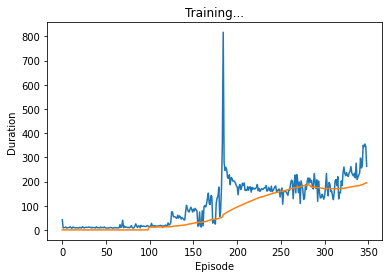

Episode 349 
 100 episode moving avg: 195.09


In [195]:
batch_size = 256
gamma = 0.99
eps_start = 1
eps_end = 0.1
eps_decay = 0.01
target_update = 20 # how frequently we update the target network
memory_size = 150000
lr = 0.001 # learning rate
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

#policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
#target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
policy_net = DQN(em.num_state_features()).to(device) # remove this line for original code.
target_net = DQN(em.num_state_features()).to(device) # remove this line for original code.
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()

    for timestep in count():
        em.render()
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if get_moving_average(100, episode_durations)[-1] >= 195:
        break

em.close()